## Mock / Basic Analysis

We performed a preliminary analysis on MSFT stock data, using features such as daily return, RSI, moving averages, and volume. 

A baseline linear regression model was trained to predict next-day closing prices.

Initial results show that adding transformed RSI features (RSI² and RSI³) improved R² from 0.36 to 0.47 and reduced RMSE from 0.039 to 0.035. 

Residual analysis indicates reasonable model fit with no extreme outliers.

0. Setup & Imports

In [30]:
import os
import sys
from pathlib import Path
import pathlib
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import skew, kurtosis
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

sns.set(context='talk', style='whitegrid')

# Set project root
PROJECT_ROOT = Path("D:/文心远/研究生/5040-Bootcamp/project").resolve()
os.chdir(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

from src.utils import ts, safe_filename, write_df, read_df
from src.eda import eda_summary
from src.features import create_stock_features
from src.models import fit_linear_model, save_model, load_model, fit_and_metrics


# Load environment variables
load_dotenv(PROJECT_ROOT / ".env")

# Data directories
RAW_DIR = PROJECT_ROOT / os.getenv("DATA_DIR_RAW")
PROC_DIR = PROJECT_ROOT / os.getenv("DATA_DIR_PROCESSED")
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = PROJECT_ROOT / "deliverables" / "images"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("RAW_DIR:", RAW_DIR)
print("PROC_DIR:", PROC_DIR)


RAW_DIR: D:\文心远\研究生\5040-Bootcamp\project\data\raw
PROC_DIR: D:\文心远\研究生\5040-Bootcamp\project\data\processed


1. Load Data

In [3]:
# Load latest preprocessed CSV
csv_files = sorted(RAW_DIR.glob("api_source-yfinance_symbol-MSFT_*.csv"))
latest_csv = csv_files[-1]
df_raw = pd.read_csv(latest_csv, parse_dates=['date'])
df_raw = df_raw.sort_values('date').reset_index(drop=True)

print("Loaded raw CSV:", latest_csv)
df_raw.head()


Loaded raw CSV: D:\文心远\研究生\5040-Bootcamp\project\data\raw\api_source-yfinance_symbol-MSFT_20250821-215314.csv


,date,open,high,low,close,adj_close,volume
0,2025-02-24,408.510010,409.369995,399.320007,404.000000,403.259674,26443700
1,2025-02-25,401.100006,401.920013,396.700012,397.899994,397.170837,29387400
2,2025-02-26,398.010010,403.600006,394.250000,399.730011,398.997498,19619000
3,2025-02-27,401.269989,405.739990,392.170013,392.529999,391.810699,21127400
4,2025-02-28,392.660004,397.630005,386.570007,396.989990,396.262512,32845700


2. Data Cleaning & Validation

In [4]:
from src.cleaning import preprocess_df

# Clean data
df_cleaned = preprocess_df(df_raw)

# Save cleaned data
clean_csv_path = PROC_DIR / "MSFT_preprocessed.csv"
df_cleaned.to_csv(clean_csv_path, index=False)
print("Saved cleaned data:", clean_csv_path)

# Quick validation
print(df_cleaned.info())
df_cleaned.head()


Saved cleaned data: D:\文心远\研究生\5040-Bootcamp\project\data\processed\MSFT_preprocessed.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       125 non-null    datetime64[ns]
 1   open       125 non-null    float64       
 2   high       125 non-null    float64       
 3   low        125 non-null    float64       
 4   close      125 non-null    float64       
 5   adj_close  125 non-null    float64       
 6   volume     125 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 7.0 KB
None


,date,open,high,low,close,adj_close,volume
0,2025-02-24,0.282016,0.235063,0.291433,0.273028,0.271554,0.309973
1,2025-02-25,0.245755,0.196052,0.277430,0.239342,0.238049,0.372483
2,2025-02-26,0.230634,0.204849,0.264336,0.249448,0.248100,0.165049
3,2025-02-27,0.246587,0.216055,0.253220,0.209686,0.208554,0.197080
4,2025-02-28,0.204453,0.173587,0.223291,0.234316,0.233051,0.445921


3. Feature Engineering

In [5]:
df_features = create_stock_features(df_cleaned)
df_features.to_csv(PROC_DIR / 'MSFT_features.csv', index=False)
print("Saved features to PROC_DIR")


Saved features to PROC_DIR


d:\Software\Miniconda3\envs\fe-course\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


4. Exploratory Data Analysis (EDA)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
open,125.0,0.474047,0.274167,0.0,0.192072,0.509273,0.722241,1.0,-0.039889,-1.421278
high,125.0,0.458105,0.286726,0.0,0.150547,0.498036,0.730429,1.0,-0.022080,-1.457713
low,125.0,0.528859,0.300606,0.0,0.217786,0.583133,0.817487,1.0,-0.107083,-1.477917
close,125.0,0.516076,0.303714,0.0,0.198918,0.567705,0.811354,1.0,-0.092728,-1.486778
adj_close,125.0,0.515993,0.304372,0.0,0.197843,0.569250,0.812029,1.0,-0.093140,-1.491132
volume,125.0,0.220918,0.182022,0.0,0.098162,0.172137,0.252997,1.0,1.969759,4.295790


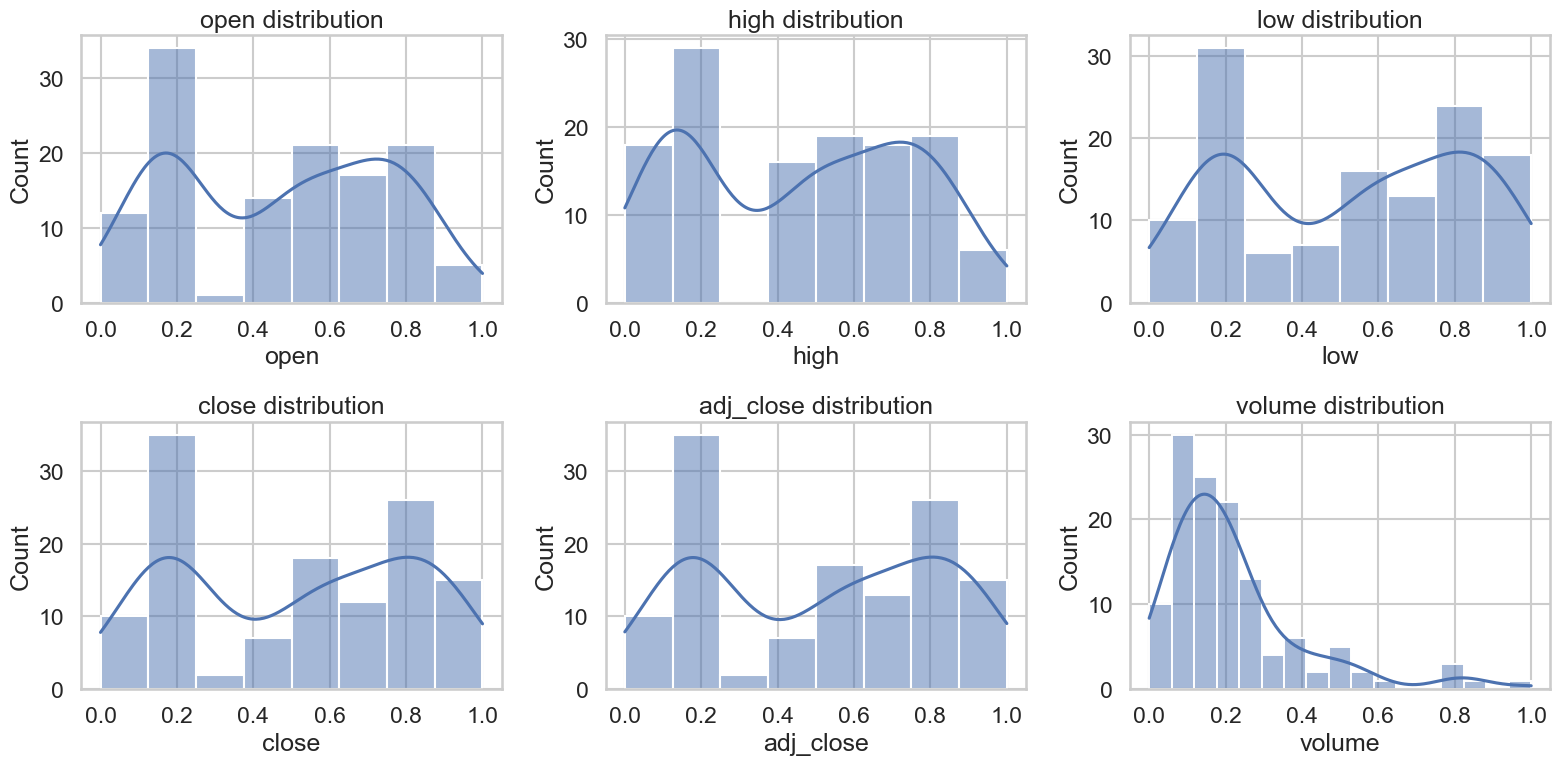

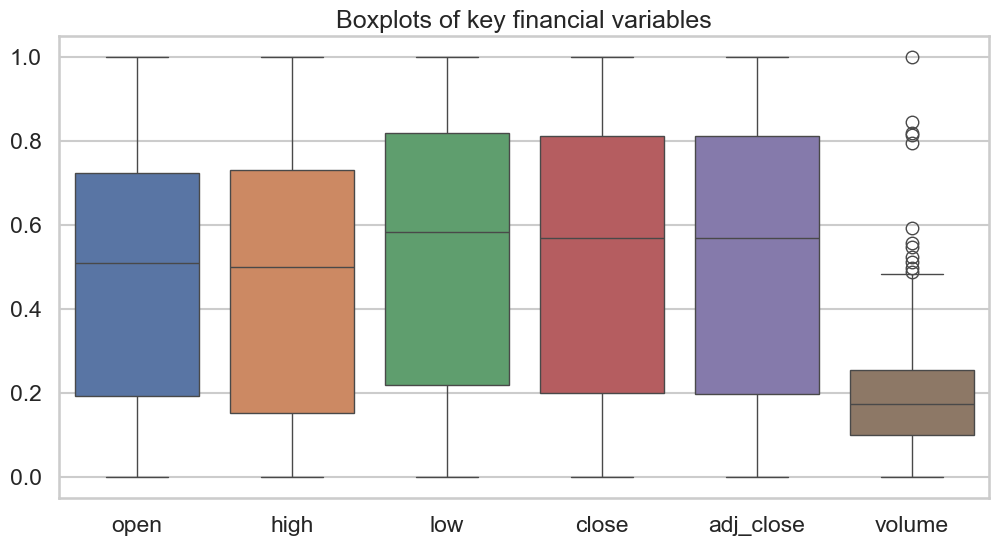

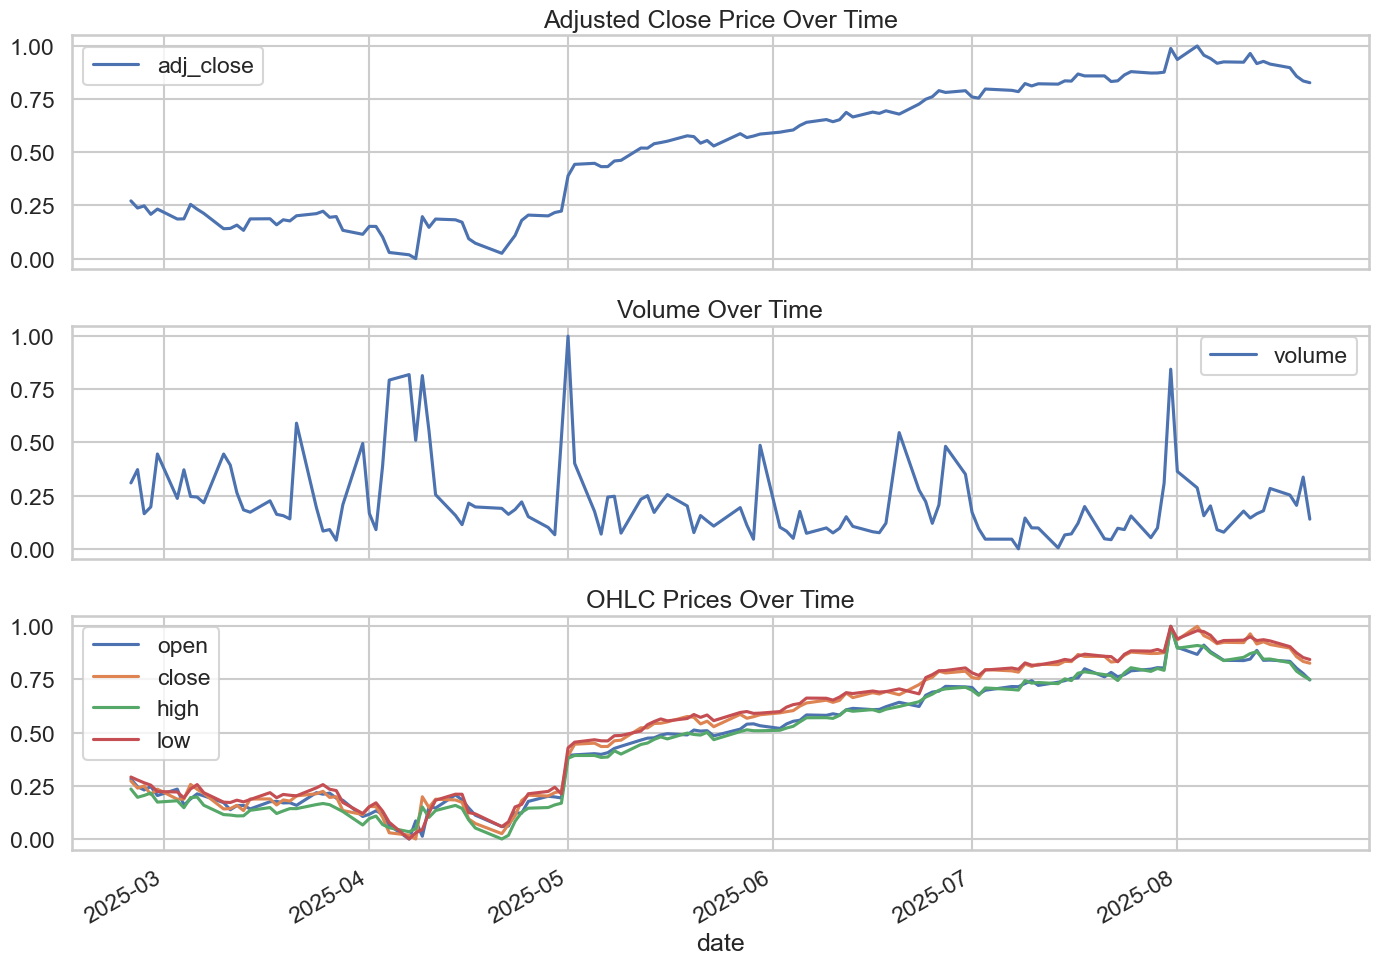

In [6]:
numeric_cols = ["open", "high", "low", "close", "adj_close", "volume"]

# Summary stats
desc = df_features[numeric_cols].describe().T
desc["skew"] = [skew(df_features[c].dropna()) for c in numeric_cols]
desc["kurtosis"] = [kurtosis(df_features[c].dropna()) for c in numeric_cols]
display(desc)

# Histograms
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for ax, col in zip(axes.flatten(), numeric_cols):
    sns.histplot(df_features[col], kde=True, ax=ax)
    ax.set_title(f"{col} distribution")
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=df_features[numeric_cols])
plt.title("Boxplots of key financial variables")
plt.show()

# Time series plots
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
df_features.plot(x="date", y="adj_close", ax=axes[0], title="Adjusted Close Price Over Time")
df_features.plot(x="date", y="volume", ax=axes[1], title="Volume Over Time")
df_features[["date","open","close","high","low"]].set_index("date").plot(ax=axes[2], title="OHLC Prices Over Time")
plt.tight_layout()
plt.show()


5. Outlier Handling

In [7]:
from src.outliers import detect_outliers_dataframe, winsorize_series

# Detect outliers
df_outliers_iqr = detect_outliers_dataframe(df_features, numeric_cols, method="iqr", k=1.5)
df_outliers_z = detect_outliers_dataframe(df_features, numeric_cols, method="zscore", threshold=3.0)

# Winsorization
df_winsorized = df_features.copy()
for col in numeric_cols:
    df_winsorized[f"{col}_w"] = winsorize_series(df_features[col], lower=0.05, upper=0.95)


6. Linear Regression Modeling

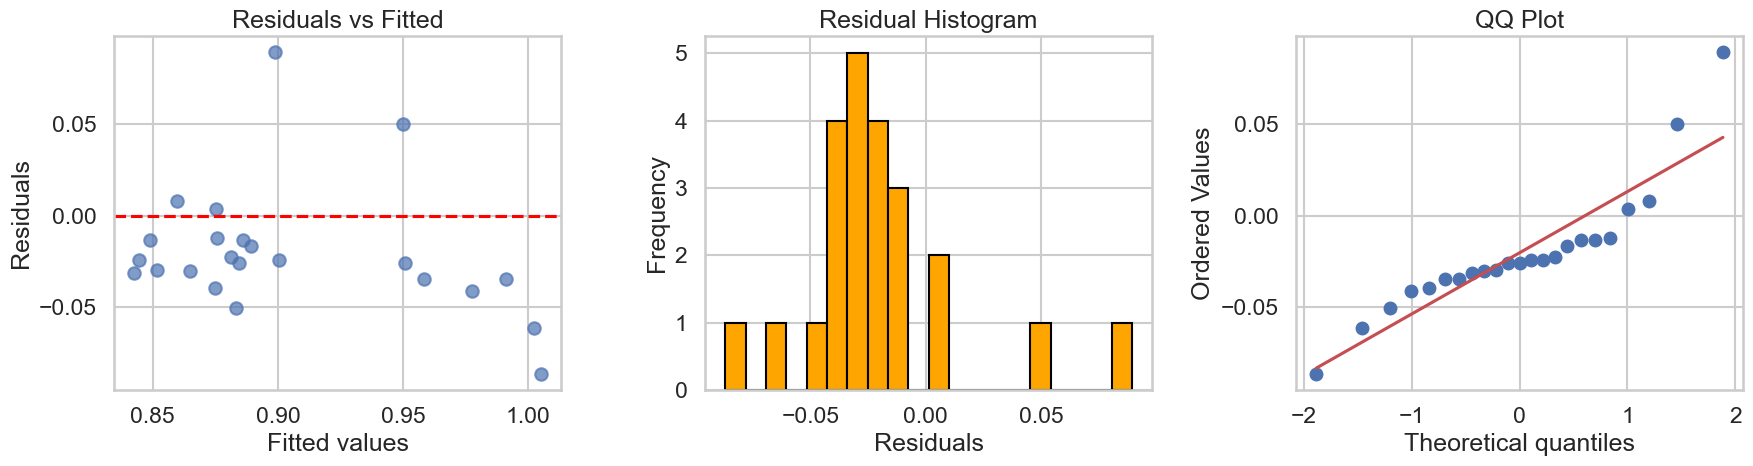

In [41]:
# Features and target
feature_cols = [
    "daily_return", "log_return", "volatility_5d", "ma_5", "ma_20", 
    "ma_spread", "vol_mean_5", "hl_spread", "co_diff", "rsi", "momentum_5", "log_volume", "rsi_ma5"
]

df_features['close_next'] = df_features['close'].shift(-1)
df_features = df_features[:-1]  # remove last row without target

X = df_features[feature_cols].replace([np.inf, -np.inf], 0)
y = df_features["close_next"]

mask = X.replace([np.inf, -np.inf], np.nan).notna().all(axis=1) & y.notna()
X_clean = X[mask]
y_clean = y[mask]

# Train-test split (80/20)

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, shuffle=False
)


# Baseline Linear Regression

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Residual diagnostics

resid = y_test - y_pred
fitted = y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals vs Fitted
axes[0].scatter(fitted, resid, alpha=0.7)
axes[0].axhline(0, ls='--', color='red')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

# Histogram of residuals
axes[1].hist(resid, bins=20, color='orange', edgecolor='black')
axes[1].set_title('Residual Histogram')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')

# QQ Plot
st.probplot(resid, dist='norm', plot=axes[2])
axes[2].set_title('QQ Plot')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "baseline_residuals.png")
plt.show()


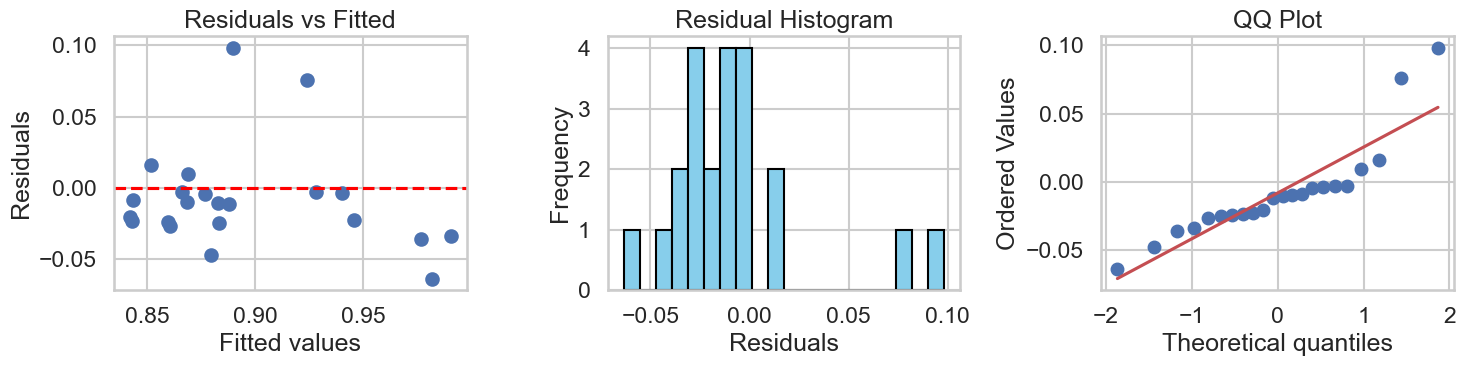

In [42]:
# Add transformed feature

df_features["rsi_sq"] = df_features["rsi"]**2
df_features["rsi_cube"] = df_features["rsi"]**3

feature_cols2 = feature_cols + ["rsi_sq"] + ["rsi_cube"]
X2 = df_features[feature_cols2]
y2 = df_features["close_next"]

mask = X2.replace([np.inf, -np.inf], np.nan).notna().all(axis=1) & y2.notna()
X2_clean = X2[mask]
y2_clean = y2[mask]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_clean, y2_clean, test_size=0.2, shuffle=False
)

lr2 = LinearRegression().fit(X2_train, y2_train)
y_pred2 = lr2.predict(X2_test)

resid2 = y2_test - y_pred2
fitted2 = y_pred2


plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,3)

# Residuals vs Fitted
ax0 = plt.subplot(gs[0,0])
ax0.scatter(fitted2, resid2)
ax0.axhline(0, ls='--', color='red')
ax0.set_title('Residuals vs Fitted')
ax0.set_xlabel("Fitted values")
ax0.set_ylabel("Residuals")

# Histogram of residuals
ax1 = plt.subplot(gs[0,1])
ax1.hist(resid2, bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Residual Histogram')
ax1.set_xlabel("Residuals")
ax1.set_ylabel("Frequency")

# QQ Plot
ax2 = plt.subplot(gs[0,2])
st.probplot(resid2, dist='norm', plot=ax2)
ax2.set_title('QQ Plot')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "rsi_residuals.png")
plt.show()


In [43]:
mae_base = mean_absolute_error(y_test, y_pred)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred))
r2_base = r2_score(y_test, y_pred)

mae_rsi = mean_absolute_error(y2_test, y_pred2)
rmse_rsi = np.sqrt(mean_squared_error(y2_test, y_pred2))
r2_rsi = r2_score(y2_test, y_pred2)

print(f"Baseline: RMSE={rmse_base:.4f}, MAE={mae_base:.4f}, R²={r2_base:.4f}")
print(f"RSI²³:    RMSE={rmse_rsi:.4f}, MAE={mae_rsi:.4f}, R²={r2_rsi:.4f}")

Baseline: RMSE=0.0400, MAE=0.0335, R²=0.4375
RSI²³:    RMSE=0.0358, MAE=0.0262, R²=0.5286


7. Prediction vs True Values

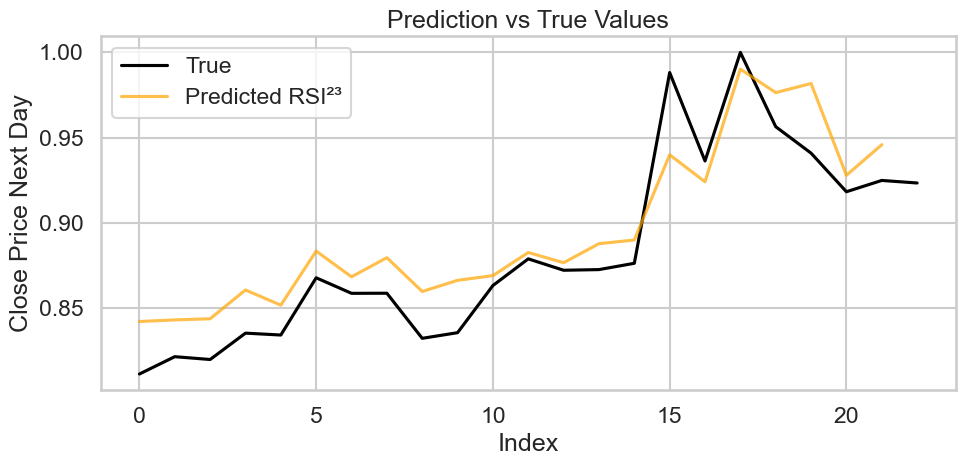

In [44]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='True', color='black')
plt.plot(y_pred2, label='Predicted RSI²³', color='orange', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Close Price Next Day')
plt.title('Prediction vs True Values')
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "prediction_vs_true.png")
plt.show()

8. Save Final Model

In [47]:
import pickle

model = LinearRegression()
model.fit(X_clean, y_clean)

MODEL_DIR = PROJECT_ROOT / "model"
MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / "final_model.pkl"

with open(model_path, "wb") as f:
    pickle.dump(model, f)

print("Model saved to:", model_path)


Model saved to: D:\文心远\研究生\5040-Bootcamp\project\model\final_model.pkl


9. Flask API Test

{'error': 'X has 3 features, but LinearRegression is expecting 15 features as input.'}
{'prediction': 0.06963959546284665}
{'prediction': 0.16842829982211147}



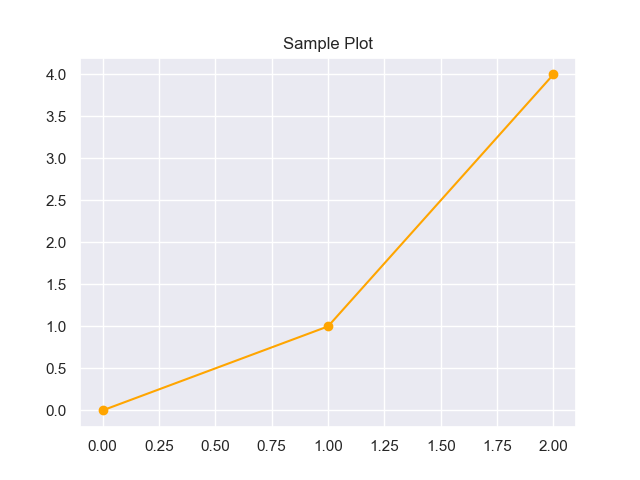

In [48]:
import requests
from IPython.display import display, HTML

# POST /predict
response = requests.post('http://127.0.0.1:5000/predict', json={'features':[0.1, 0.2, 0.3]})
print(response.json())

# GET /predict/<input1>
response2 = requests.get('http://127.0.0.1:5000/predict/2.0')
print(response2.json())

# GET /predict/<input1>/<input2>
response3 = requests.get('http://127.0.0.1:5000/predict/1.0/3.0')
print(response3.json())

# GET /plot
response_plot = requests.get('http://127.0.0.1:5000/plot')
display(HTML(response_plot.text))
